In [7]:
#QUESTION 1

import os
import sqlite3
import pandas as pd

# Load CSV to DataFrame
cwd = os.getcwd()
csv_HD = os.path.join(cwd, 'heart.csv')
df = pd.read_csv(csv_HD)

# Create SQLite connection
conn = sqlite3.connect('heart_disease.db')
cursor = conn.cursor()

# Create table and insert data
df.to_sql('heart_disease', conn, if_exists='replace', index=False)

# Verify the table
DB_query = "SELECT * FROM heart_disease LIMIT 12;"
result = cursor.execute(DB_query).fetchall()
print(result)

conn.close()


[('63;1;3;145;233;1;0;150;0;2.3;0;0;1;1',), ('37;1;2;130;250;0;1;187;0;3.5;0;0;2;1',), ('41;0;1;130;204;0;0;172;0;1.4;2;0;2;1',), ('56;1;1;120;236;0;1;178;0;0.8;2;0;2;1',), ('57;0;0;120;354;0;1;163;1;0.6;2;0;2;1',), ('57;1;0;140;192;0;1;148;0;0.4;1;0;1;1',), ('56;0;1;140;294;0;0;153;0;1.3;1;0;2;1',), ('44;1;1;120;263;0;1;173;0;0;2;0;3;1',), ('52;1;2;172;199;1;1;162;0;0.5;2;0;3;1',), ('57;1;2;150;168;0;1;174;0;1.6;2;0;2;1',), ('54;1;0;140;239;0;1;160;0;1.2;2;0;2;1',), ('48;0;2;130;275;0;1;139;0;0.2;2;0;2;1',)]


In [21]:
import pandas as pd
import sqlite3
from sklearn.preprocessing import StandardScaler

# Load CSV into DataFrame with correct delimiter
df = pd.read_csv('heart.csv', delimiter=';')

# Check if data is correctly loaded
print(df.head())
print(df.dtypes)

# Convert relevant columns to numeric (if needed)
df = df.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# Handle missing values (if any)
df.fillna(df.mean(), inplace=True)

# Encode categorical variables
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Normalize numerical variables
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Check the cleaned data
print(df.head())
print(df.dtypes)

# Save the preprocessed data to SQLite database
conn = sqlite3.connect('heart_disease.db')
df.to_sql('heart_disease', conn, if_exists='replace', index=False)
conn.close()


   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object
        age  trestbps      chol   thalach   oldpeak  target  sex_1   cp_1  \
0  0.95219

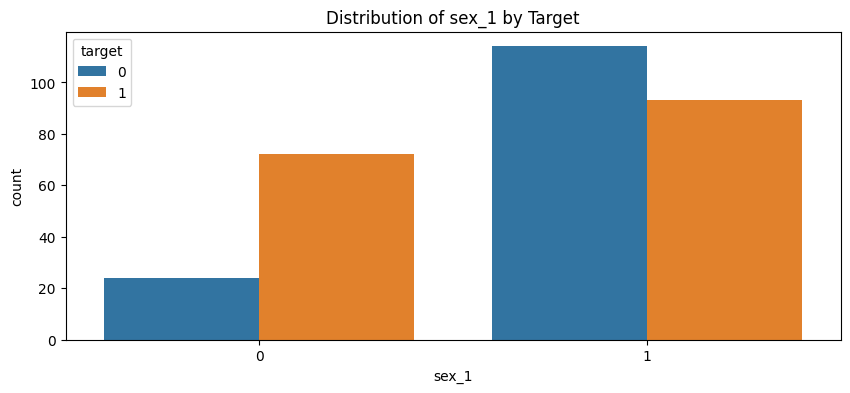

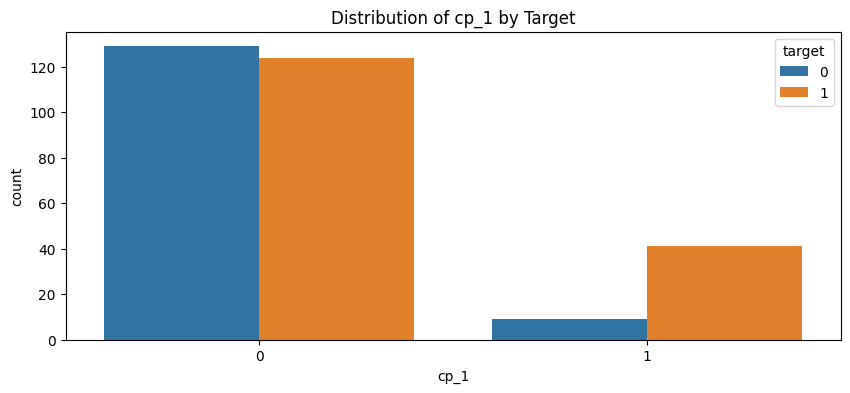

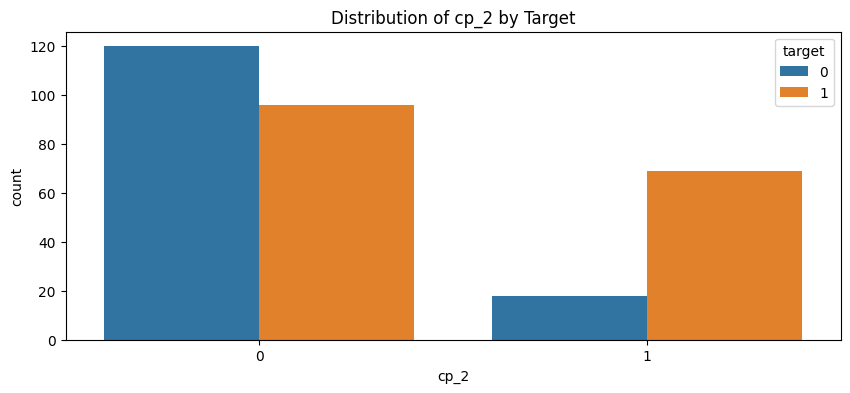

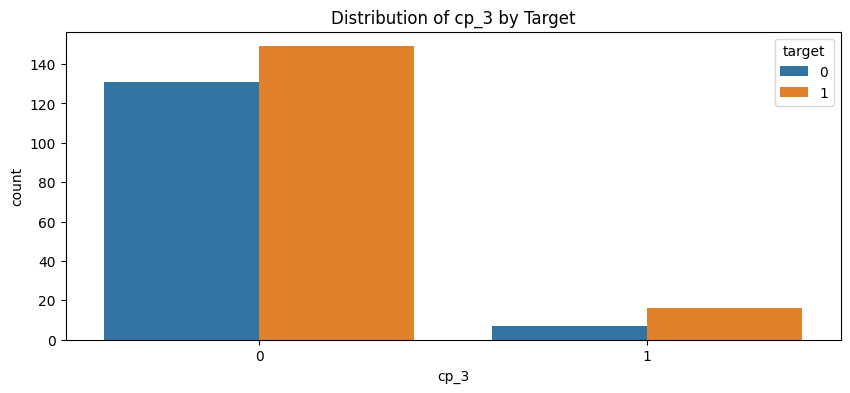

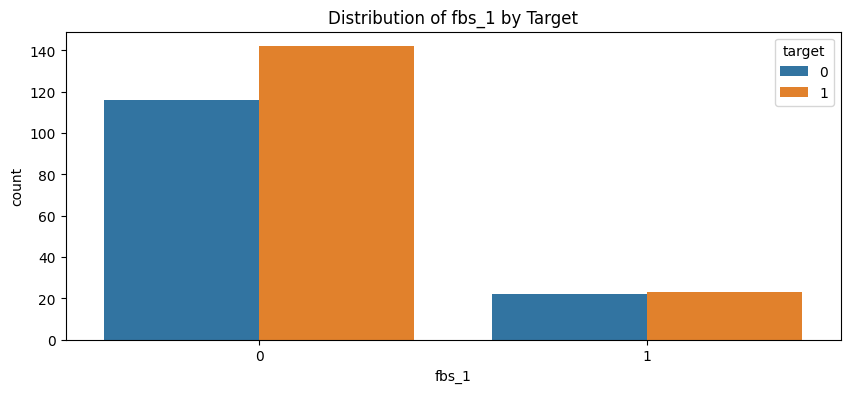

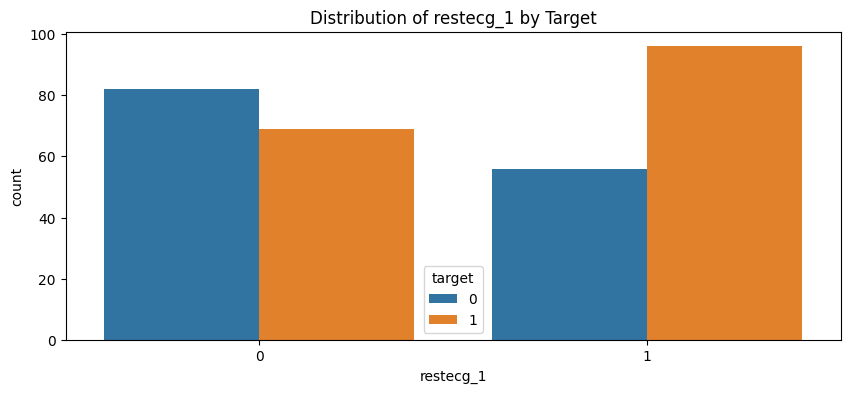

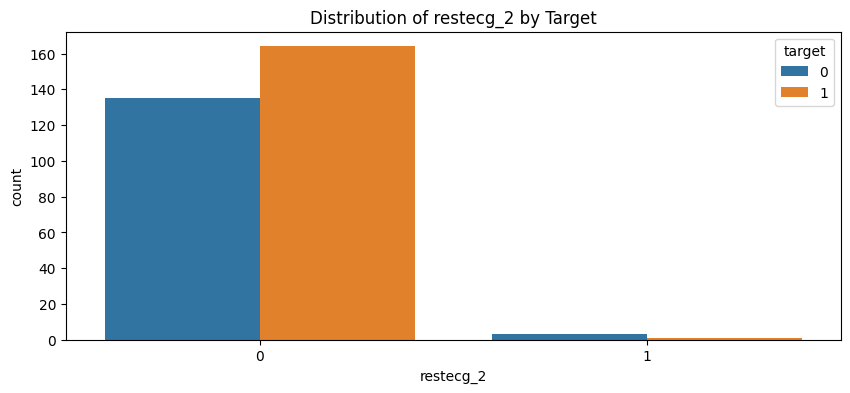

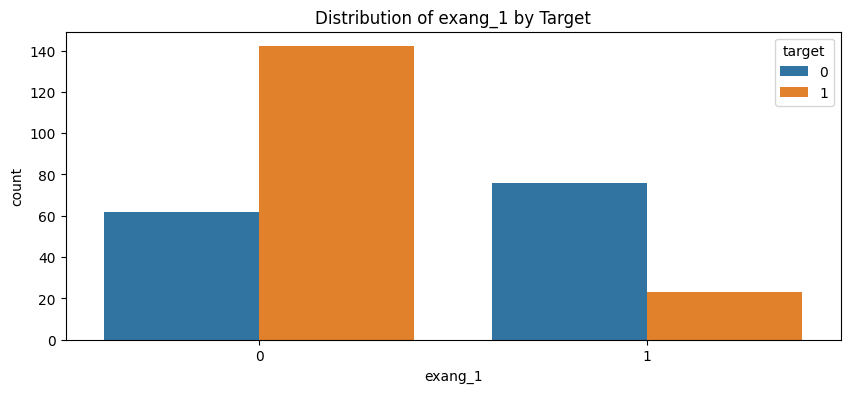

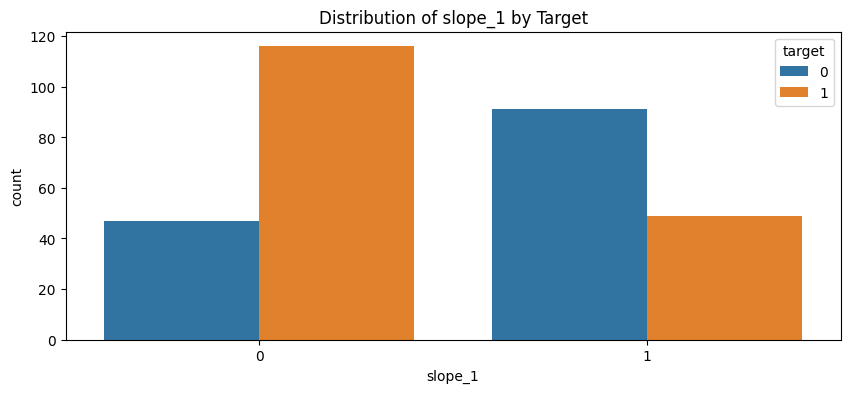

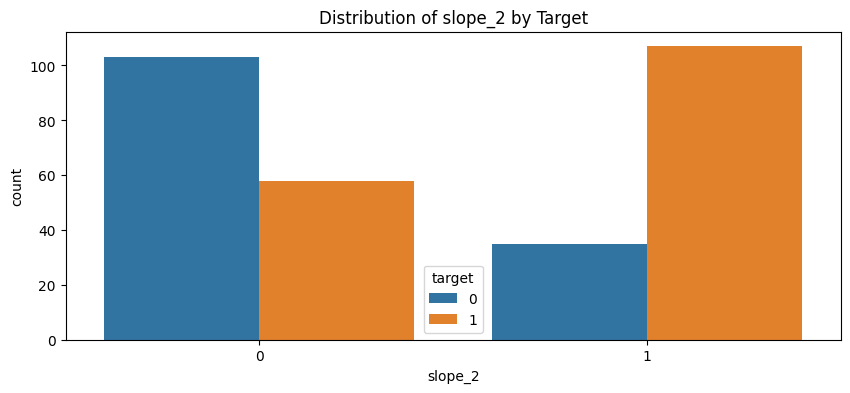

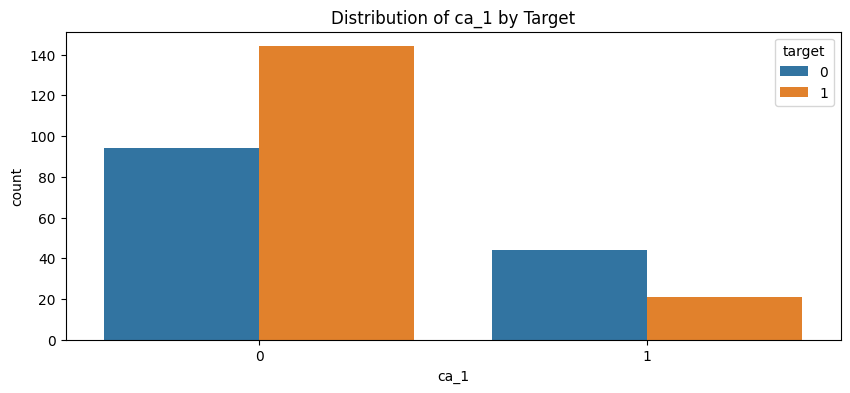

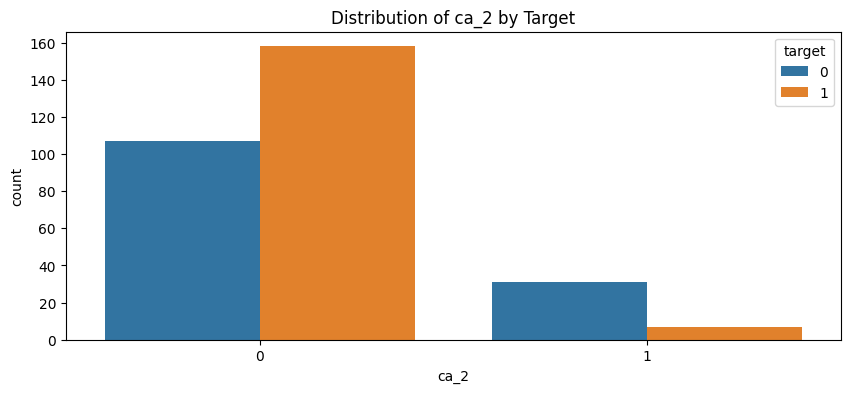

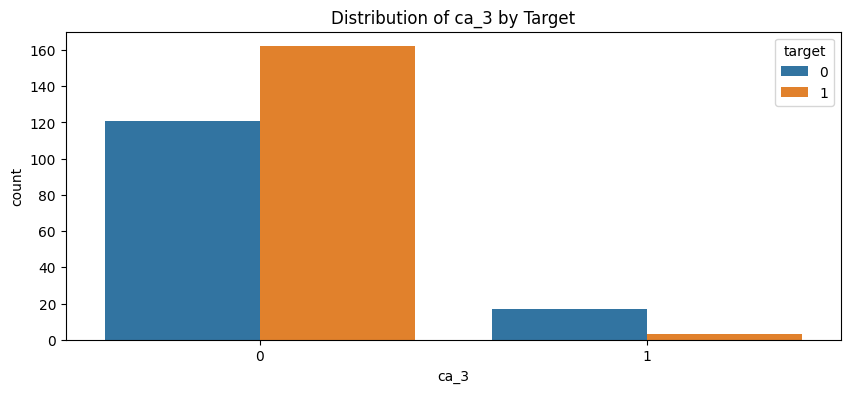

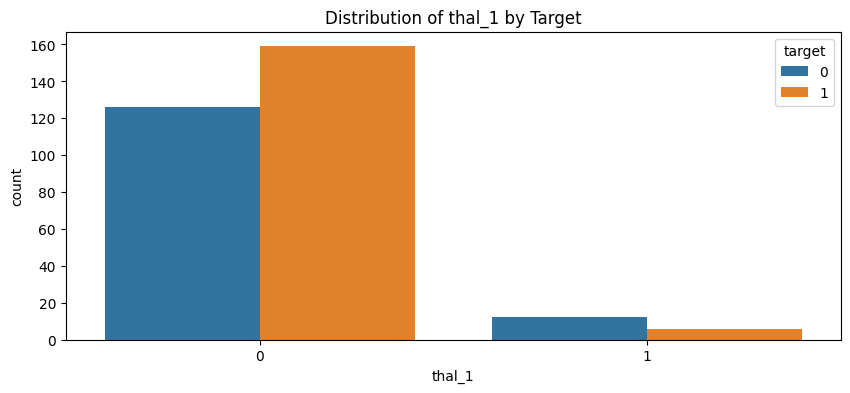

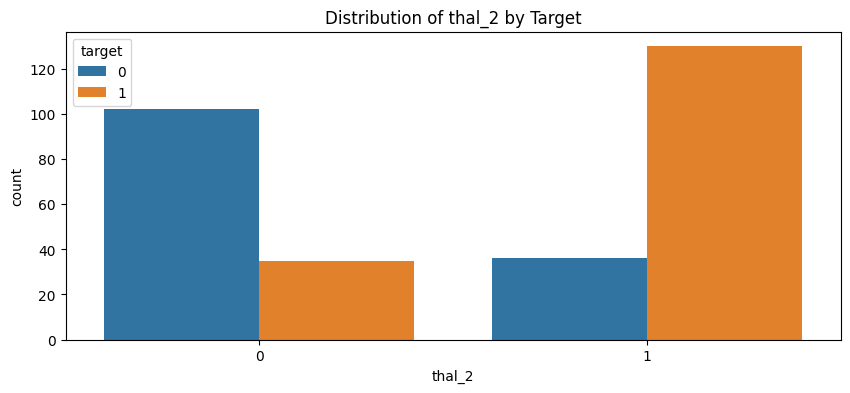

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reconnect to SQLite database
conn = sqlite3.connect('heart_disease.db')
df = pd.read_sql_query("SELECT * FROM heart_disease", conn)
conn.close()

# Plot categorical variable distributions
categorical_cols = ['sex_1', 'cp_1', 'cp_2', 'cp_3', 'fbs_1', 'restecg_1', 'restecg_2', 'exang_1', 'slope_1', 'slope_2', 'ca_1', 'ca_2', 'ca_3', 'thal_1', 'thal_2']
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=col, hue='target', data=df)
    plt.title(f'Distribution of {col} by Target')
    plt.show()


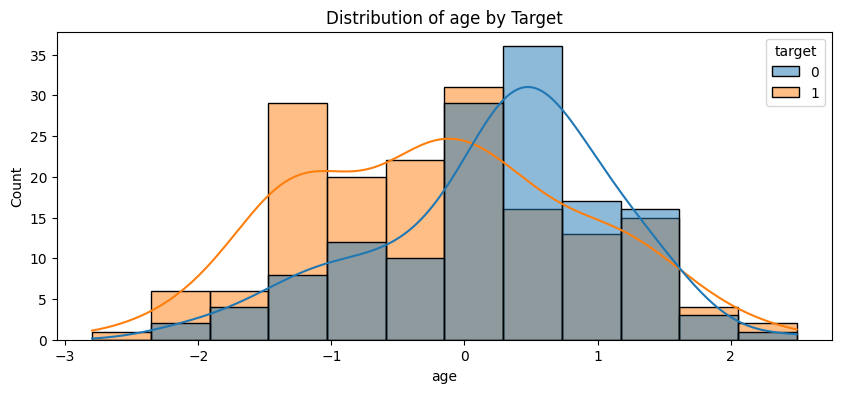

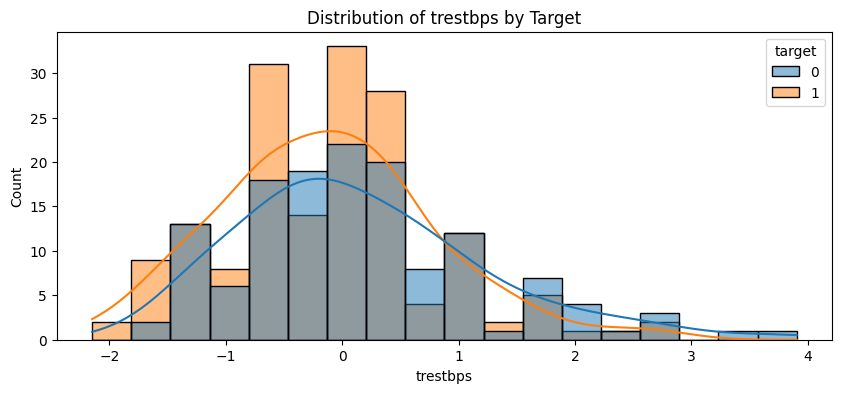

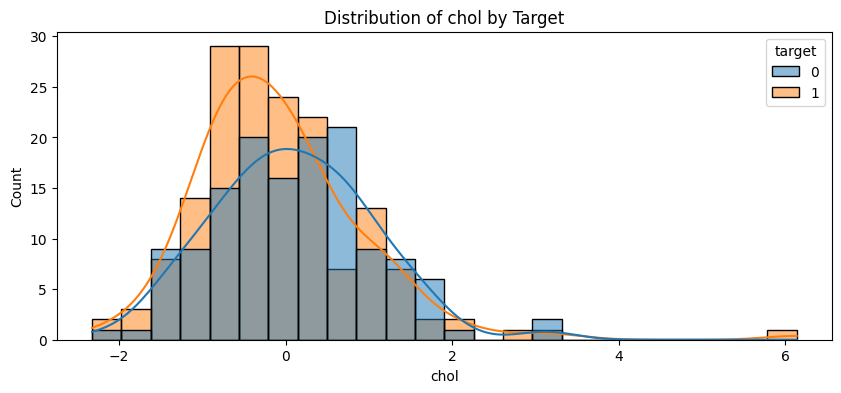

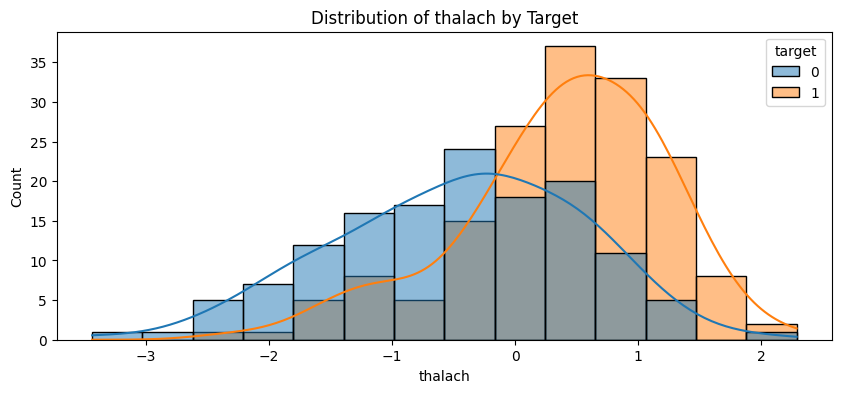

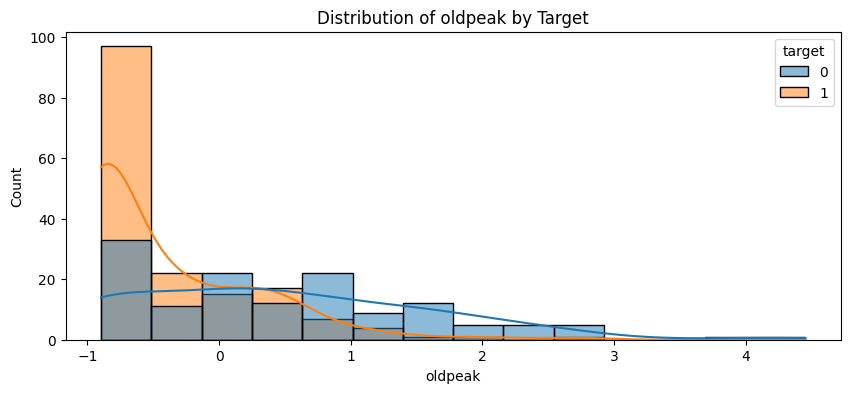

In [25]:
# Plot numerical variable distributions
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
for col in numerical_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(df, x=col, hue='target', kde=True)
    plt.title(f'Distribution of {col} by Target')
    plt.show()


In [26]:
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split

# Reconnect to SQLite database
conn = sqlite3.connect('heart_disease.db')
df = pd.read_sql_query("SELECT * FROM heart_disease", conn)
conn.close()

# Split the data into features and target
X = df.drop('target', axis=1)
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (242, 22)
Test set size: (61, 22)


In [28]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
import pickle

# Initialize models
xgb_clf = xgb.XGBClassifier(random_state=42)
lgb_clf = lgb.LGBMClassifier(random_state=42)

# Fit the models
xgb_clf.fit(X_train, y_train)
lgb_clf.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_clf.predict(X_test)
y_pred_lgb = lgb_clf.predict(X_test)

# Evaluate models
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)

print("XGBoost Accuracy:", accuracy_xgb)
print("LightGBM Accuracy:", accuracy_lgb)

print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("LightGBM Classification Report:\n", classification_report(y_test, y_pred_lgb))

# Save the best model to disk
best_model = lgb_clf if accuracy_lgb > accuracy_xgb else xgb_clf
with open('best_gbm_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [36]:
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import pickle

# Load the preprocessed data
conn = sqlite3.connect('heart_disease.db')
df = pd.read_sql_query("SELECT * FROM heart_disease", conn)
conn.close()

# Split the data into features and target
X = df.drop('target', axis=1)
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data for SVC
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit Random Forest model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Make predictions with Random Forest
y_pred_rf_clf = rf_clf.predict(X_test)
y_pred_rf_clf_proba = rf_clf.predict_proba(X_test)[:, 1]

# Evaluate Random Forest model
accuracy_rf_clf = accuracy_score(y_test, y_pred_rf_clf)
roc_auc_rf_clf = roc_auc_score(y_test, y_pred_rf_clf_proba)
print("Random Forest Classifier Accuracy:", accuracy_rf_clf)
print("Random Forest Classifier AUC-ROC:", roc_auc_rf_clf)
print("Random Forest Classifier Report:\n", classification_report(y_test, y_pred_rf_clf))

# Initialize and fit SVC model
svm_clf = SVC(kernel='linear', probability=True)
svm_clf.fit(X_train_scaled, y_train)

# Make predictions with SVC
y_pred_svm_clf = svm_clf.predict(X_test_scaled)
y_pred_svm_clf_proba = svm_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate SVC model
accuracy_svm_clf = accuracy_score(y_test, y_pred_svm_clf)
roc_auc_svm_clf = roc_auc_score(y_test, y_pred_svm_clf_proba)
print("Support Vector Machine Accuracy:", accuracy_svm_clf)
print("Support Vector Machine AUC-ROC:", roc_auc_svm_clf)
print("Support Vector Machine Report:\n", classification_report(y_test, y_pred_svm_clf))

# Initialize and fit XGBoost model
xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)

# Make predictions with XGBoost
y_pred_xgb = xgb_clf.predict(X_test)
y_pred_xgb_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Evaluate XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb_proba)
print("XGBoost Accuracy:", accuracy_xgb)
print("XGBoost AUC-ROC:", roc_auc_xgb)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Determine the best model based on accuracy and AUC-ROC
best_model = None
best_model_name = ''
best_metric = max((accuracy_rf_clf, roc_auc_rf_clf), (accuracy_svm_clf, roc_auc_svm_clf), (accuracy_xgb, roc_auc_xgb), key=lambda x: x[1])

if best_metric == (accuracy_rf_clf, roc_auc_rf_clf):
    best_model = rf_clf
    best_model_name = 'Random Forest'
elif best_metric == (accuracy_svm_clf, roc_auc_svm_clf):
    best_model = svm_clf
    best_model_name = 'SVM'
else:
    best_model = xgb_clf
    best_model_name = 'XGBoost'

# Save the best model and scaler to disk
with open('best_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

# Save the final features
with open('features.pkl', 'wb') as feature_file:
    pickle.dump(X.columns.tolist(), feature_file)

print(f"Best model saved: {best_model_name}")


Random Forest Classifier Accuracy: 0.8524590163934426
Random Forest Classifier AUC-ROC: 0.9283405172413792
Random Forest Classifier Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85        29
           1       0.90      0.81      0.85        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61

Support Vector Machine Accuracy: 0.8524590163934426
Support Vector Machine AUC-ROC: 0.9321120689655172
Support Vector Machine Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.87      0.84      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61

XGBoost Accuracy: 0.8360655737704918
XGBoost AUC-ROC: 0.90409482758620

In [41]:
import streamlit as st
import pandas as pd
import numpy as np
import pickle

# Load the best model
with open('best_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Load the scaler
with open('scaler.pkl', 'rb') as scaler_file:
    scaler = pickle.load(scaler_file)

# Load the features
with open('features.pkl', 'rb') as feature_file:
    features = pickle.load(feature_file)

# Function to get user input
def get_user_input():
    user_data = {}
    user_data['age'] = st.sidebar.number_input('age', 0, 120, 25)
    user_data['sex'] = st.sidebar.selectbox('sex', [0, 1])
    user_data['cp'] = st.sidebar.selectbox('cp', [0, 1, 2, 3])
    user_data['trestbps'] = st.sidebar.number_input('trestbps', 0, 200, 120)
    user_data['chol'] = st.sidebar.number_input('chol', 0, 600, 200)
    user_data['fbs'] = st.sidebar.selectbox('fbs', [0, 1])
    user_data['restecg'] = st.sidebar.selectbox('restecg', [0, 1, 2])
    user_data['thalach'] = st.sidebar.number_input('thalach', 0, 220, 150)
    user_data['exang'] = st.sidebar.selectbox('exang', [0, 1])
    user_data['oldpeak'] = st.sidebar.number_input('oldpeak', 0.0, 10.0, 1.0)
    user_data['slope'] = st.sidebar.selectbox('slope', [0, 1, 2])
    user_data['ca'] = st.sidebar.selectbox('ca', [0, 1, 2, 3, 4])
    user_data['thal'] = st.sidebar.selectbox('thal', [0, 1, 2, 3])

    features_df = pd.DataFrame(user_data, index=[0])
    return features_df

# Get user input
user_input = get_user_input()

# One-hot encode the categorical features
user_input_encoded = pd.get_dummies(user_input)

# Align the input features with the training features
user_input_aligned = user_input_encoded.reindex(columns=features, fill_value=0)

# Set the title
st.title("Heart Disease Prediction")

# Display the user input
st.subheader('User Input:')
st.write(user_input_aligned)

# Standardize the user input (apply the same scaling as used in training)
user_input_scaled = scaler.transform(user_input_aligned)

# Make predictions
prediction = model.predict(user_input_scaled)
prediction_proba = model.predict_proba(user_input_scaled)

# Display the prediction
st.subheader('Prediction:')
st.write('Heart Disease' if prediction[0] == 1 else 'No Heart Disease')

# Display the prediction probability
st.subheader('Prediction Probability:')
st.write(prediction_proba)
